In [24]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

az.style.use("arviz-darkgrid")
SEED = 7355608

In [25]:
data = bmb.load_data("ANES")
data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


In [26]:
clinton_data = data.loc[data["vote"].isin(["clinton", "trump"]), :]

In [27]:
clinton_model = bmb.Model("vote['clinton'] ~ party_id + party_id:age", clinton_data, family="bernoulli")
clinton_fitted = clinton_model.fit(
    draws=2000, target_accept=0.85, random_seed=SEED, idata_kwargs={"log_likelihood": True}
)

Modeling the probability that vote==clinton
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, party_id, party_id:age]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 37 seconds.


In [28]:
clinton_model.predict(clinton_fitted, kind="response")

In [29]:
parties = ["democrat", "independent", "republican"]
dem, ind, rep = [clinton_fitted.posterior["party_id:age"].sel({"party_id:age_dim":party}) for party in parties]

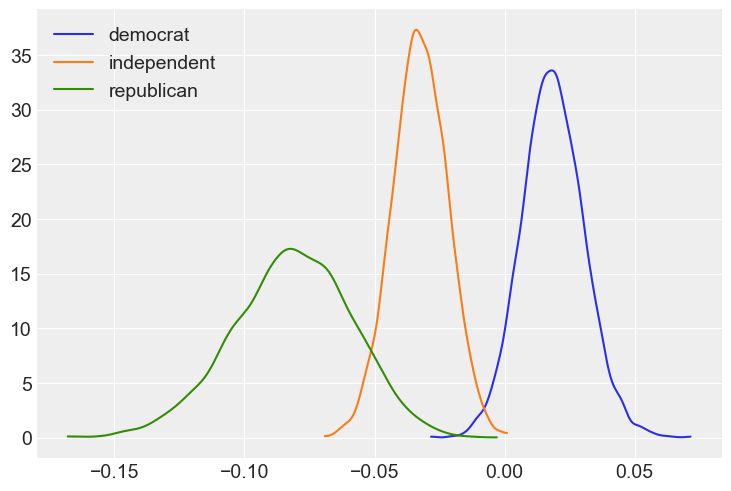

In [30]:
_, ax = plt.subplots()
for idx, x in enumerate([dem, ind, rep]):
    az.plot_dist(x, label=x["party_id:age_dim"].item(), plot_kwargs={"color": f"C{idx}"}, ax=ax)
ax.legend(loc="upper left");

In [31]:
age = np.arange(18, 91)
new_data = pd.DataFrame({
    "age": np.tile(age, 3),
    "party_id": np.repeat(["democrat", "republican", "independent"], len(age))
})
new_data

,age,party_id
0,18,democrat
1,19,democrat
2,20,democrat
3,21,democrat
4,22,democrat
...,...,...
214,86,independent
215,87,independent
216,88,independent
217,89,independent


In [32]:
clinton_model.predict(clinton_fitted, data=new_data)

In [33]:
az.summary(clinton_fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.383,0.545,0.355,2.421,0.007,0.006,6468.0,4722.0,1.0
party_id[independent],-0.028,0.653,-1.233,1.239,0.009,0.008,5703.0,5016.0,1.0
party_id[republican],-0.595,0.808,-2.150,0.874,0.011,0.009,5850.0,5255.0,1.0
party_id:age[democrat],0.019,0.012,-0.005,0.040,0.000,0.000,6160.0,4874.0,1.0
party_id:age[independent],-0.033,0.011,-0.053,-0.014,0.000,0.000,6811.0,4707.0,1.0
...,...,...,...,...,...,...,...,...,...
p[214],0.199,0.070,0.079,0.333,0.001,0.001,7175.0,6223.0,1.0
p[215],0.195,0.070,0.076,0.329,0.001,0.001,7163.0,6096.0,1.0
p[216],0.190,0.070,0.072,0.325,0.001,0.001,7148.0,6095.0,1.0
p[217],0.186,0.070,0.068,0.321,0.001,0.001,7136.0,6171.0,1.0


In [39]:
# Select a sample of posterior values for the mean probability of voting for Clinton
vote_posterior = az.extract(clinton_fitted, num_samples=2000)["p"]
vote_posterior

<xarray.DataArray 'p' (__obs__: 219, sample: 2000)> Size: 4MB
array([[0.87274474, 0.77111294, 0.8837585 , ..., 0.86091654, 0.79440348,
        0.81839642],
       [0.87502219, 0.77729636, 0.8845848 , ..., 0.8630321 , 0.80007624,
        0.82145219],
       [0.87726461, 0.78335966, 0.88540599, ..., 0.86512053, 0.80563078,
        0.82446757],
       ...,
       [0.18351253, 0.22510967, 0.25294828, ..., 0.20739393, 0.29930726,
        0.2186009 ],
       [0.17834368, 0.22059389, 0.24842671, ..., 0.20289799, 0.29556319,
        0.21281317],
       [0.17328952, 0.21614343, 0.24395956, ..., 0.19847511, 0.29184645,
        0.20713806]], shape=(219, 2000))
Coordinates:
  * __obs__  (__obs__) int64 2kB 0 1 2 3 4 5 6 7 ... 212 213 214 215 216 217 218
  * sample   (sample) object 16kB MultiIndex
  * chain    (sample) int64 16kB 1 0 3 1 0 0 3 3 0 2 3 ... 0 3 2 0 0 1 0 1 2 0 0
  * draw     (sample) int64 16kB 1221 957 666 1455 495 ... 509 99 1392 1549 6

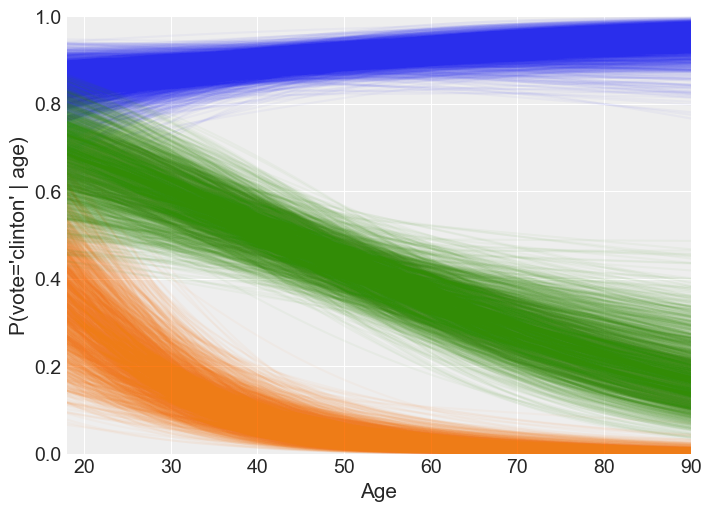

In [37]:
_, ax = plt.subplots(figsize=(7, 5))
for i, party in enumerate(["democrat", "republican", "independent"]):
    # Which rows in new_data correspond to party?
    idx = new_data.index[new_data["party_id"] == party].tolist()
    ax.plot(age, vote_posterior[idx], alpha=0.04, color=f"C{i}")

ax.set_ylabel("P(vote='clinton' | age)")
ax.set_xlabel("Age", fontsize=15)
ax.set_ylim(0, 1)
ax.set_xlim(18, 90);

In [38]:
print(vote_posterior[1])

<xarray.DataArray 'p' (sample: 2000)> Size: 16kB
array([0.782358  , 0.84627239, 0.8129167 , ..., 0.85800118, 0.89948584,
       0.81274296], shape=(2000,))
Coordinates:
    __obs__  int64 8B 1
  * sample   (sample) object 16kB MultiIndex
  * chain    (sample) int64 16kB 3 2 3 0 1 0 2 2 3 0 2 ... 3 3 1 1 2 1 1 2 3 2 1
  * draw     (sample) int64 16kB 1832 1911 746 242 250 ... 1264 1351 1573 666
